In [5]:
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

In [6]:
dir = '/Users/adityavs14/Documents/Internship/Pianalytix/SPRXRAY/ML_model/kaggle/'

df_age = pd.read_csv(dir+'train_age.csv')
df_gen = pd.read_csv(dir+'train_gender.csv')

print(df_age.head())
print(df_gen.head())

   imageId   age
0        0  89.0
1        1  72.0
2        2  25.0
3        3  68.0
4        4  37.0
   imageId  gender
0        0       0
1        1       0
2        2       1
3        3       1
4        4       0


In [7]:
im=[]
for i in tqdm(sorted(os.listdir(dir+'kaggle/kaggle/train/'))):
    img = cv2.imread(dir+'kaggle/kaggle/train/'+i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = 255-img # creating the negative of the image
    img = cv2.resize(img,(128, 128))
    im.append(img)
    #img.append(plt.imread(dir+'kaggle/kaggle/train/'+i))
age = df_age['age']
gen= df_gen['gender']
data ={'Image': im,'Age':age,'Gender':gen}
        

100%|█████████████████████████████████████| 10702/10702 [02:36<00:00, 68.29it/s]


In [10]:
df = pd.DataFrame(data)

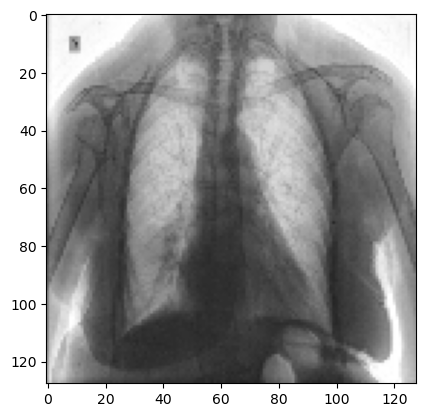

In [11]:
plt.imshow(cv2.cvtColor(df['Image'].iloc[0], cv2.COLOR_BGR2RGB))

# Gender Prediction

In [12]:
X = np.array(data['Image'])
y = np.array(data['Gender'])

X = X.reshape((X.shape[0],X.shape[1],X.shape[2],1))
y = y.reshape(-1,1)
X = X/255
print(X.shape, y.shape)

(10702, 128, 128, 1) (10702, 1)


# Gender DCNN model

In [13]:
import tensorflow
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPool2D, Activation, BatchNormalization

Init Plugin
Init Graph Optimizer
Init Kernel


In [14]:
def blockc(y,filt,kern):
    x = tensorflow.keras.layers.Conv2D(filt,kern, padding = 'same')(y)
    x = tensorflow.keras.layers.MaxPool2D(2 , strides = 2, padding = 'same')(x)
    x = tensorflow.keras.layers.BatchNormalization()(x)
    x = tensorflow.keras.layers.Activation('relu')(x)
    return x

In [15]:
#define model
tensorflow.keras.backend.clear_session()
model_gender = tensorflow.keras.Sequential()


inp = tensorflow.keras.layers.Input((128, 128,1))
c0 = tensorflow.keras.layers.Conv2D(4,3, padding = 'same')(inp)
c0 = tensorflow.keras.layers.MaxPool2D(2)(c0)
c1 = blockc(c0,16,3)
c2 = blockc(c1,32,3)
c3 = blockc(c2,64,3)
c4 = blockc(c3,128,3)
c5 = blockc(c4,64,3)
c6 = blockc(c5,32,3)
c6 =tensorflow.keras.layers.GlobalAveragePooling2D()(c6)
out = tensorflow.keras.layers.Dense(1,activation='sigmoid')(c6)
model_gender = tensorflow.keras.Model(inputs = [inp], outputs = [out])
 

Metal device set to: Apple M1


2023-04-25 08:50:04.486871: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-25 08:50:04.487016: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [16]:
model_gender.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_gender.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 4)       40        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        592       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 32, 32, 16)        0     

In [17]:
history = model_gender.fit(
    X,y,
    steps_per_epoch = (10000//10),
    validation_split=0.2,
    epochs = 5
)

2023-04-25 08:50:05.441912: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-25 08:50:05.445518: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/5


2023-04-25 08:50:05.806274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 997/1000 [============================>.] - ETA: 0s - loss: 0.4265 - accuracy: 0.8058

2023-04-25 08:50:29.527964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1000/1000 [==============================] - 25s 20ms/step - loss: 0.4261 - accuracy: 0.8061 - val_loss: 0.3513 - val_accuracy: 0.8398
Epoch 2/5
1000/1000 [==============================] - 15s 15ms/step - loss: 0.2735 - accuracy: 0.8944 - val_loss: 0.2845 - val_accuracy: 0.8870
Epoch 3/5
1000/1000 [==============================] - 15s 15ms/step - loss: 0.2117 - accuracy: 0.9236 - val_loss: 0.2604 - val_accuracy: 0.9010
Epoch 4/5
1000/1000 [==============================] - 15s 15ms/step - loss: 0.1738 - accuracy: 0.9398 - val_loss: 0.1218 - val_accuracy: 0.9552
Epoch 5/5
1000/1000 [==============================] - 12s 12ms/step - loss: 0.1551 - accuracy: 0.9478 - val_loss: 0.1098 - val_accuracy: 0.9603


<AxesSubplot:>

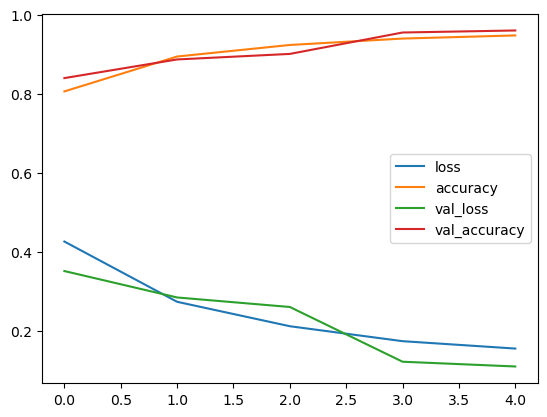

In [18]:
pd.DataFrame(history.history).plot()

In [19]:
model_gender.save('model_gender.h5')

# Age Prediction

In [20]:
y = np.array(data['Age'])
print(X.shape, y.shape)

(10702, 128, 128, 1) (10702,)


In [21]:
tensorflow.keras.backend.clear_session()
model_age = tensorflow.keras.Sequential()


inp = tensorflow.keras.layers.Input((128, 128,1))
c0 = tensorflow.keras.layers.Conv2D(4,3, padding = 'same')(inp)
c0 = tensorflow.keras.layers.MaxPool2D(2)(c0)
c1 = blockc(c0,16,3)
c2 = blockc(c1,32,3)
c3 = blockc(c2,64,3)
c4 = blockc(c3,128,3)
c5 = blockc(c4,64,3)
c6 = blockc(c5,32,3)
c6 =tensorflow.keras.layers.GlobalAveragePooling2D()(c6)
c7 = tensorflow.keras.layers.Flatten()(c6)
c8 = tensorflow.keras.layers.Dense(100,activation='linear')(c7)
c9 = tensorflow.keras.layers.Dense(50,activation='linear')(c8)
out = tensorflow.keras.layers.Dense(1,activation='linear')(c9)
model_age = tensorflow.keras.Model(inputs = [inp], outputs = [out])
 

In [22]:
model_age.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
model_age.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 4)       40        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        592       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 32, 32, 16)        0     

In [23]:
history = model_age.fit(
    X,y,
    steps_per_epoch = (10000//10),
    validation_split=0.2,
    epochs = 10
)

Epoch 1/10


2023-04-25 08:53:54.706361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1000/1000 [==============================] - ETA: 0s - loss: 313.9880 - mse: 313.9880

2023-04-25 08:54:09.490405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1000/1000 [==============================] - 16s 15ms/step - loss: 313.9880 - mse: 313.9880 - val_loss: 235.8335 - val_mse: 235.8335
Epoch 2/10
1000/1000 [==============================] - 15s 15ms/step - loss: 161.0339 - mse: 161.0339 - val_loss: 133.3175 - val_mse: 133.3175
Epoch 3/10
1000/1000 [==============================] - 15s 15ms/step - loss: 133.7359 - mse: 133.7359 - val_loss: 120.3329 - val_mse: 120.3329
Epoch 4/10
1000/1000 [==============================] - 15s 15ms/step - loss: 123.8229 - mse: 123.8229 - val_loss: 168.3839 - val_mse: 168.3839
Epoch 5/10
1000/1000 [==============================] - 15s 15ms/step - loss: 117.1024 - mse: 117.1024 - val_loss: 97.8774 - val_mse: 97.8774
Epoch 6/10
1000/1000 [==============================] - 15s 15ms/step - loss: 103.5748 - mse: 103.5748 - val_loss: 86.5945 - val_mse: 86.5945
Epoch 7/10
1000/1000 [==============================] - 15s 15ms/step - loss: 96.3471 - mse: 96.3471 - val_loss: 115.4817 - val_mse: 115.4817
Epoch 8/1

<AxesSubplot:>

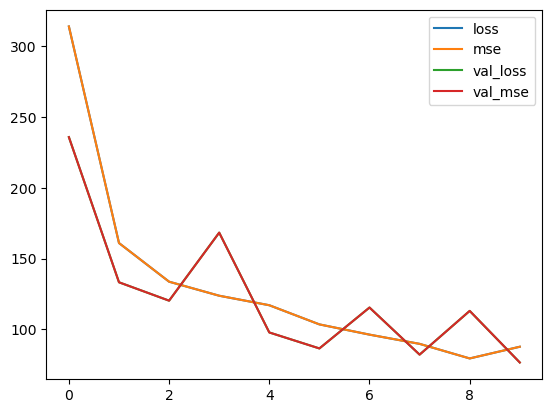

In [24]:
pd.DataFrame(history.history).plot()

In [25]:
model_age.save('model_age.h5')

# Testing the models

In [30]:
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score

y_pred = model_gender.predict(X)
pred = []
for i in tqdm(y_pred):
    if i<0.5:
        pred.append(0)
    else:
        pred.append(1)
pred = np.array(pred)

print(pred.shape,y.shape)
print(pred[5:15],gen[5:15])

100%|████████████████████████████████| 10702/10702 [00:00<00:00, 1144095.46it/s]

(10702,) (10702,)
[1 1 1 0 1 1 1 1 0 1] 5     1
6     1
7     1
8     0
9     1
10    1
11    1
12    1
13    0
14    1
Name: gender, dtype: int64


In [27]:
pred = np.round(model_age.predict(X))
print(pred[5:15],age[5:15])

2023-04-25 09:09:16.602436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[68.]
 [50.]
 [49.]
 [71.]
 [40.]
 [75.]
 [64.]
 [58.]
 [74.]
 [35.]] 5     62.0
6     52.0
7     46.0
8     83.0
9     33.0
10    82.0
11    78.0
12    61.0
13    74.0
14    28.0
Name: age, dtype: float64


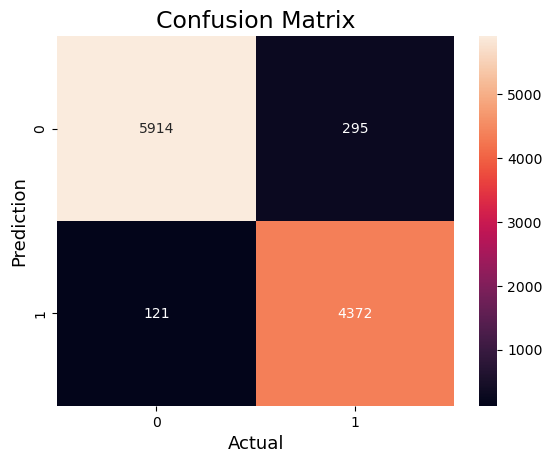

Accuracy   : 0.9611287609792563
Precision : 0.9367902292693379
Recall    : 0.9730692187847764
F1-score  : 0.9545851528384279


In [31]:
import seaborn as sns
cm = confusion_matrix(gen,pred)
 
#Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
            fmt='g')
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()
accuracy = accuracy_score(gen, pred)
print("Accuracy   :", accuracy)
precision = precision_score(gen, pred)
print("Precision :", precision)
recall = recall_score(gen, pred)
print("Recall    :", recall)
F1_score = f1_score(gen, pred)
print("F1-score  :", F1_score)


In [29]:
from sklearn.metrics import r2_score

p = model_age.predict(X)

print(r2_score(age,p))


0.8014806121732889
